## Предсказание законтрактованности путём агрегации данных о предыдущих поставках

Мы проведём сравнение двух методов:
1) Усреднение параметров поставок (таких как процент опоздания по поставкам и изменение качества)
2) Усреднение эмбеддингов предыдущих поставок, полученных через LSTM автоэнкодер

In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
import os
sys.path.append(os.path.abspath('..'))
from data import feature_generation
from figures.plots import show_embeddings
from src.metrics import mapk

import warnings
warnings.filterwarnings('ignore')

In [2]:
feature_generation.EMBED_PATH = '../data/processed_data/embed_df.csv'
data = feature_generation.pipeline()
data.head(2)

,supplier,id,spec_date,delivery_period_end,bids_contracted,is_late,is_underweight,is_poorquality,supplier_status,option,...,6,7,8,9,10,11,12,13,14,15
0,50 ЛЕТ ОКТЯБРЯ ООО,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2022-12-19",2022-12-19,2022-12-25,1.0,0.0,1.0,1.0,1.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50 ЛЕТ ОКТЯБРЯ ООО,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2023-01-24",2023-01-24,2023-02-12,1.0,0.0,0.0,0.0,1.0,15.0,...,-0.610757,0.14691,-0.80265,0.722523,-0.47786,-0.424774,0.521571,-0.012061,0.157792,0.696974


In [3]:
"""
Разделение набора данных
"""

split_point = np.quantile(data['spec_date'], 0.9)
train_spec = data.loc[data['spec_date'] < split_point]
test_spec = data.loc[data['spec_date'] >= split_point]

X_train = train_spec.drop(['bids_contracted', 'is_late', 'is_underweight', 'is_poorquality'], axis=1)
y_train = train_spec['bids_contracted']

X_test = test_spec.drop(['bids_contracted', 'is_late', 'is_underweight', 'is_poorquality'], axis=1)
y_test = test_spec['bids_contracted']

features = {'zpp4': ['supplier_lateness', 'supplier_underweight', 'supplier_price_change'],
            'embed': [str(i) for i in range(16)],
            'spec': ['mean_delivery_length', 'delivery_length_diff', 'mean_volume', 'volume_diff', 'conversion']}

In [4]:
X = data.drop(['bids_contracted', 'is_late', 'is_underweight', 'is_poorquality'], axis=1)
y = data['bids_contracted']

## Предсказание законтрактованности независимо от даты

In [5]:
def dayseparately(X, y, features, predict_func):
    actual = []
    predicted = []
    
    days_indexes = X.groupby('spec_date').apply(lambda x: x.index)
    for day in days_indexes:
        actual.append(list(y.loc[day].values))
        predicted.append(list(predict_func(X[features].loc[day])))
    
    return actual, predicted

def sep_by(X, y, features, predict_func, series):
    actual = []
    predicted = []
    
    groups = X.groupby(series).apply(lambda x: x.index)
    for group in groups:
        actual.append(list(y.loc[group].values))
        predicted.append(list(predict_func(X[features].loc[group])))
    
    return actual, predicted

In [6]:
groups = data.groupby(data['spec_date'].dt.to_period('M')).apply(lambda x: x.index)
groups = groups.sort_index()

In [26]:
groups

spec_date
2022-07    Int64Index([ 114,  376,  501,  502,  599,  715...
2022-08    Int64Index([ 109,  115,  116,  183,  213,  377...
2022-09    Int64Index([  83,   89,   90,   97,   98,  117...
2022-10    Int64Index([   9,   13,   20,   21,   22,   23...
2022-11    Int64Index([  10,   11,   14,   15,   24,   40...
2022-12    Int64Index([   0,   43,   44,   61,   62,   63...
2023-01    Int64Index([   1,   25,   45,   46,   71,  106...
2023-02    Int64Index([   5,    6,    7,   12,   16,   17...
2023-03    Int64Index([   2,    8,   18,   47,   48,   76...
2023-04    Int64Index([   3,   27,   49,   50,   78,  110...
2023-05    Int64Index([   4,   19,   28,   29,   30,   31...
2023-06    Int64Index([  33,   34,   35,   36,   37,   38...
2023-07    Int64Index([  39,   88,  270,  407,  481,  662...
Freq: M, dtype: object

In [7]:
X_train = pd.concat([X.loc[group] for group in groups[:7]])
y_train = pd.concat([y.loc[group] for group in groups[:7]])

group_predictions = []

for group in groups[7:]:
    X_test = X.loc[group]
    y_test = y.loc[group]
    
    model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed'] + features['spec']], y_train)

    actual, predicted = dayseparately(X_test, y_test, features['embed'] + features['spec'], lambda x: model.predict_proba(x)[:, 1])
    
    group_predictions.append(mapk(actual, predicted))
    
    X_train = pd.concat([X_train, X_test])
    y_train = pd.concat([y_train, y_test])

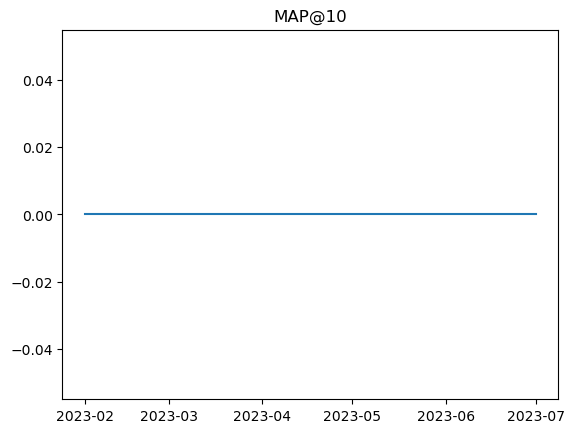

In [8]:
plt.title('MAP@10')
plt.plot(groups.index[7:].to_timestamp(), group_predictions)
# plt.savefig('../figures/map@10.jpg', bbox_inches='tight')

In [9]:
actual

[[1.0, 0.0, 0.0],
 [0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0],
 [0.0, 0.0],
 [1.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0],
 [0.0, 0.0, 1.0, 1.0],
 [1.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0]]

In [10]:
predicted

[[0.392672153308768, 0.31425522114149845, 0.3113486970626611],
 [0.7077726081618865, 0.8065436578425813],
 [0.6541467494342288,
  0.7470677255100309,
  0.20751112989392212,
  0.6732883974117,
  0.5682323313594019,
  0.30333791088844003,
  0.4704020424566272,
  0.3943012571797782],
 [0.8584100467252268,
  0.30333791088844003,
  0.8533520263676506,
  0.36013296619902985,
  0.19040815340001563,
  0.4946796666975256,
  0.34691841528487916,
  0.38814631421887685],
 [0.3061639095402806,
  0.666664644947646,
  0.20470189975238837,
  0.5135519762388675,
  0.34604155707856027,
  0.30333791088844003,
  0.17264500738392327,
  0.34696184507537936,
  0.17264500738392327,
  0.16622388121660867,
  0.3567367225142843],
 [0.3633767907176467,
  0.24234230404591434,
  0.16057375920938233,
  0.28789312598745503,
  0.28789312598745503,
  0.8661019033571143,
  0.6135928820482294,
  0.615086748123282,
  0.37610598361478825],
 [0.8499016799599164, 0.6713050587695106],
 [0.7747024594817593, 0.2904037728632602]

In [17]:
"""
Предсказание законтрактованности (Средние параметры поставок)
"""

def estimate(model, X_test, y_test):
    accuracy = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Accuracy: {accuracy}\nROC AUC: {roc_auc}')

print('Бустинг (Средние параметры поставок):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4']], y_train)
estimate(model, X_test[features['zpp4']], y_test)

Бустинг (Средние параметры поставок):
Accuracy: 0.6047904191616766
ROC AUC: 0.6295572916666665


In [18]:
"""
Предсказание законтрактованности (Эмбеддинг)
"""

print('Бустинг (эмбеддинг):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed']], y_train)
estimate(model, X_test[features['embed']], y_test)

Бустинг (эмбеддинг):
Accuracy: 0.6182634730538922
ROC AUC: 0.6661413433908046


In [19]:
"""
Предсказание законтрактованности (Средние параметры поставок + средние параметры спецификаций)
"""
print('Бустинг (Средние параметры поставок + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4'] + features['spec']], y_train)
estimate(model, X_test[features['zpp4'] + features['spec']], y_test)

Бустинг (Средние параметры поставок + средние параметры спецификаций):
Accuracy: 0.6586826347305389
ROC AUC: 0.7257543103448275


In [20]:
"""
Предсказание законтрактованности (Эмбеддинг + средние параметры спецификаций)
"""
print('Бустинг (Эмбеддинг + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=32).fit(X_train[features['embed'] + features['spec']], y_train)
estimate(model, X_test[features['embed'] + features['spec']], y_test)

Бустинг (Эмбеддинг + средние параметры спецификаций):
Accuracy: 0.6736526946107785
ROC AUC: 0.7300152658045976


## Предсказание законтрактованности отдельно по дням

In [5]:
print('Бустинг (Агрегации поставок):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['zpp4'], lambda x: model.predict(x))
print(f'MAP@k: {mapk(actual, predicted)}')

Бустинг (Агрегации поставок):
0.277136351808483


In [6]:
print('Бустинг (Эмбеддинг):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['embed'], lambda x: model.predict(x))
print(f'MAP@k: {mapk(actual, predicted)}')

Бустинг (Эмбеддинг):
0.29171675774134787


In [16]:
def batch_roc_auc(actual, predicted):
    return np.mean([(roc_auc_score(real, pred) if len(np.unique(real)) > 1 else 1.) for (real, pred) in zip(actual, predicted)])

print('Бустинг (Средние параметры поставок):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['zpp4'], lambda x: model.predict_proba(x)[:, 1])
print(f'ROC AUC: {batch_roc_auc(actual, predicted)}')

Бустинг (Агрегации поставок):
ROC AUC: 0.7348193960789928


In [17]:
print('Бустинг (Эмбеддинг):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['embed'], lambda x: model.predict_proba(x)[:, 1])
print(f'ROC AUC: {batch_roc_auc(actual, predicted)}')

Бустинг (Эмбеддинг):
ROC AUC: 0.7514586790542302


In [22]:
print('Бустинг (Средние параметры поставок + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['zpp4'] + features['spec'], lambda x: model.predict(x))
print(f'MAP@k: {mapk(actual, predicted)}')

Бустинг (Средние параметры поставок + средние параметры спецификаций):
MAP@k: 0.3014133923150316


In [23]:
print('Бустинг (Эмбеддинг + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=32).fit(X_train[features['embed'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['embed'] + features['spec'], lambda x: model.predict(x))
print(f'MAP@k: {mapk(actual, predicted)}')

Бустинг (Эмбеддинг + средние параметры спецификаций):
MAP@k: 0.29130410269754525


In [18]:
print('Бустинг (Средние параметры поставок + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['zpp4'] + features['spec'], lambda x: model.predict_proba(x)[:, 1])
print(f'ROC AUC: {batch_roc_auc(actual, predicted)}')

Бустинг (Средние параметры поставок + средние параметры спецификаций):
ROC AUC: 0.7868132120249683


In [19]:
print('Бустинг (Эмбеддинг + средние параметры спецификаций):')
model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['embed'] + features['spec'], lambda x: model.predict_proba(x)[:, 1])
print(f'ROC AUC: {batch_roc_auc(actual, predicted)}')

Бустинг (Эмбеддинг + средние параметры спецификаций):
ROC AUC: 0.7904219128897612


## Комбинирование переменных

In [10]:
"""
Предсказание законтрактованности (Простые агрегации + агрегации спецификаций)
"""

model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4'] + features['spec']], y_train)
estimate(model, X_test[features['zpp4'] + features['spec']], y_test)

Accuracy: 0.6586826347305389
ROC AUC: 0.7257543103448275


In [11]:
"""
Предсказание законтрактованности (Эмбеддинг + агрегации спецификаций)
"""

model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed'] + features['spec']], y_train)
estimate(model, X_test[features['embed'] + features['spec']], y_test)

Accuracy: 0.6631736526946108
ROC AUC: 0.7190283764367816


## Комбинирование переменных (отдельно по дням)

In [12]:
"""
Предсказание законтрактованности (Простые агрегации + агрегации спецификаций)
"""

model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['zpp4'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['zpp4'] + features['spec'], lambda x: model.predict(x))
print(f'{mapk(actual, predicted)}')

0.3014133923150316


In [13]:
"""
Предсказание законтрактованности (Эмбеддинг + агрегации спецификаций)
"""

model = CatBoostClassifier(verbose = 0, random_state=42).fit(X_train[features['embed'] + features['spec']], y_train)
actual, predicted = dayseparately(X_test, y_test, features['embed'] + features['spec'], lambda x: model.predict(x))
print(f'{mapk(actual, predicted)}')

0.2902112065226819
